Лабораторная работа №8. Рекуррентные нейронные сети для анализа временных рядов
======
Данные: Набор данных для прогнозирования временных рядов, который состоит из среднемесячного числа пятен на солнце, наблюдаемых с января 1749 по август 2017. Данные в виде csv-файла можно скачать на сайте Kaggle -> https://www.kaggle.com/robervalt/sunspots/


In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt

#### Загрузите данные. Изобразите ряд в виде графика. Вычислите основные характеристики временного ряда (сезонность, тренд, автокорреляцию).

In [2]:
data = pd.read_csv('/kaggle/input/sunspots/Sunspots.csv', usecols=[1,2], parse_dates=[0], index_col=0, squeeze=True)
data.head()

Date
1749-01-31     96.7
1749-02-28    104.3
1749-03-31    116.7
1749-04-30     92.8
1749-05-31    141.7
Name: Monthly Mean Total Sunspot Number, dtype: float64

In [3]:
data.index = pd.DatetimeIndex(data.index.values,
                               freq=data.index.inferred_freq)

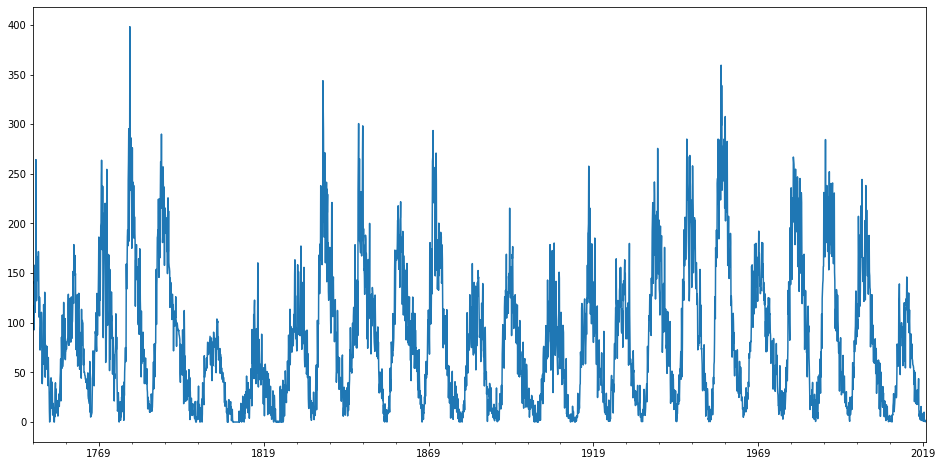

In [4]:
data.plot(figsize=(16, 8))

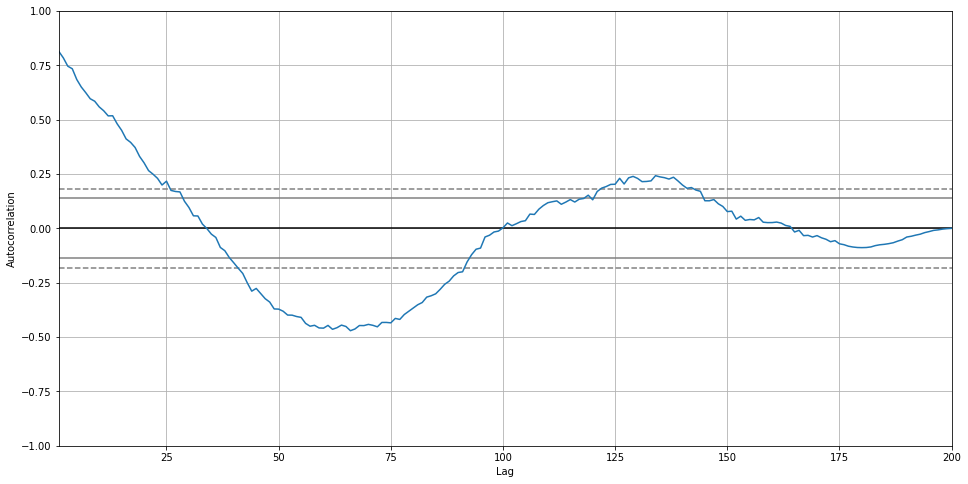

In [5]:
from pandas.plotting import autocorrelation_plot

plt.figure(figsize=(16, 8))
autocorrelation_plot(data[:200])

In [6]:
from statsmodels.tsa.arima_model import ARIMA

model = ARIMA(data, order=(25,1,0), freq=data.index.inferred_freq)
model_fit = model.fit(disp=0)
print(model_fit.summary())

                                      ARIMA Model Results                                      
Dep. Variable:     D.Monthly Mean Total Sunspot Number   No. Observations:                 3251
Model:                                 ARIMA(25, 1, 0)   Log Likelihood              -15038.442
Method:                                        css-mle   S.D. of innovations             24.698
Date:                                 Sun, 19 Apr 2020   AIC                          30130.883
Time:                                         14:17:17   BIC                          30295.224
Sample:                                     02-28-1749   HQIC                         30189.755
                                          - 12-31-2019                                         
                                                 coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------------------------
const     

                 0
count  3251.000000
mean     -0.013335
std      24.708216
min    -109.097567
25%     -12.867923
50%      -0.433795
75%      12.469070
max     144.989273


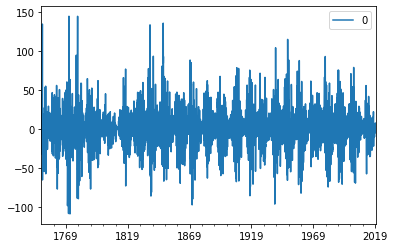

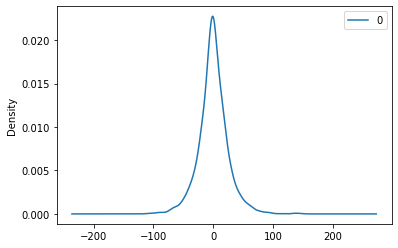

In [7]:
# plot residual errors
residuals = pd.DataFrame(model_fit.resid)
residuals.plot()
residuals.plot(kind='kde')
print(residuals.describe())

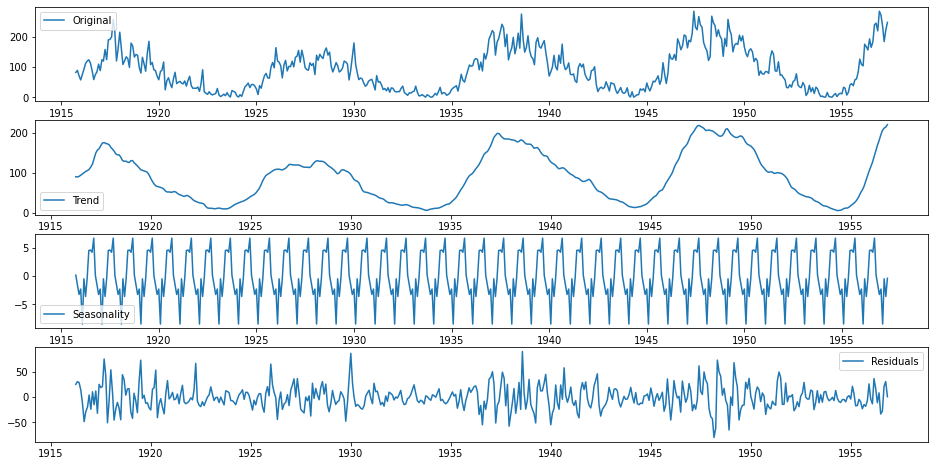

<Figure size 432x288 with 0 Axes>

In [8]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(data[2000:2500])

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.figure(figsize=(16, 8))
plt.subplot(411)
plt.plot(data[2000:2500], label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.show()
plt.tight_layout()

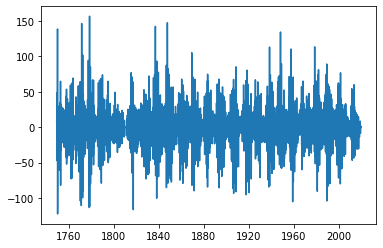

In [12]:
data_diff = data - data.shift()
plt.plot(data_diff)
plt.show()

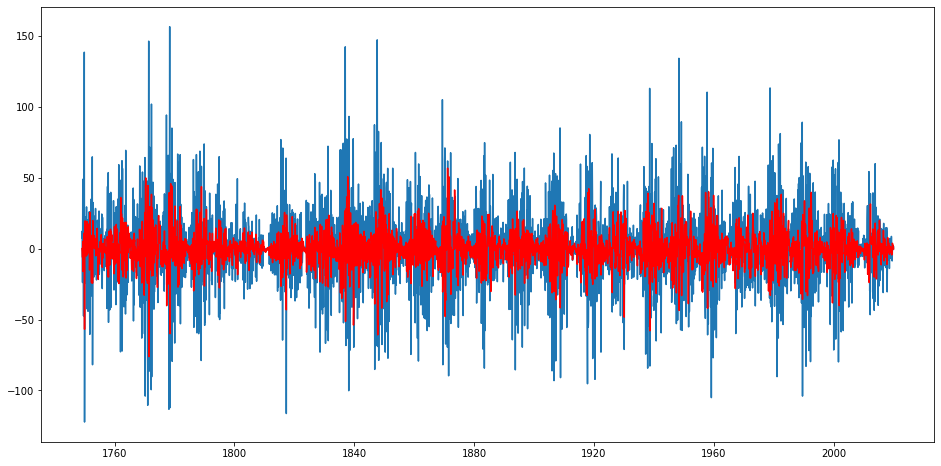

In [14]:
plt.figure(figsize=(16, 8))
plt.plot(data_diff)
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

#### Примените модель ARIMA для прогнозирования значений данного временного ряда.

In [126]:
from tqdm import tqdm
from sklearn.metrics import mean_squared_error

def evaluate_arima_model(X, order):
    # prepare training dataset
    train_size = int(len(X) * 0.8)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    # make predictions
    predictions = list()
    for t in tqdm(range(len(test))):
        model = ARIMA(history, order=order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    # calculate out of sample error
    error = mean_squared_error(test, predictions)
    return error, test, predictions

In [ ]:
mse, test, preds = evaluate_arima_model(data, order=(5,1,0))

In [144]:
print(f'ARIMA MSE={mse:.3f}')

ARIMA MSE=538.131


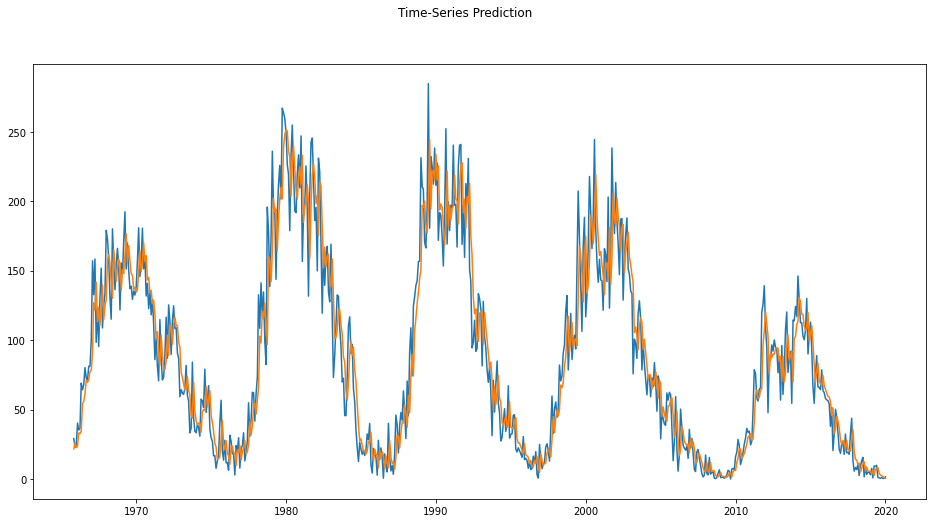

In [145]:
preds = [x[0] for x in preds]
preds = pd.Series(preds, index=test.index)

plt.figure(figsize=(16, 8))

plt.plot(test)
plt.plot(preds)
plt.suptitle('Time-Series Prediction')
plt.show()

#### Повторите эксперимент по прогнозированию, реализовав рекуррентную нейронную сеть (с как минимум 2 рекуррентными слоями).

In [26]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from sklearn.preprocessing import MinMaxScaler

In [25]:
def sliding_windows(data, seq_length):
    x = []
    y = []

    for i in range(len(data)-seq_length-1):
        _x = data[i:(i+seq_length)]
        _y = data[i+seq_length]
        x.append(_x)
        y.append(_y)

    return np.array(x),np.array(y)

In [49]:
sc = MinMaxScaler()
training_data = sc.fit_transform(data.values.reshape(-1, 1) )

In [51]:
seq_length = 30
x, y = sliding_windows(training_data, seq_length)

In [53]:
train_size = int(len(y) * 0.67)
test_size = len(y) - train_size

train_size, test_size

(2158, 1063)

In [54]:
dataX = Variable(torch.Tensor(np.array(x)))
dataY = Variable(torch.Tensor(np.array(y)))

trainX = Variable(torch.Tensor(np.array(x[0:train_size])))
trainY = Variable(torch.Tensor(np.array(y[0:train_size])))

testX = Variable(torch.Tensor(np.array(x[train_size:len(x)])))
testY = Variable(torch.Tensor(np.array(y[train_size:len(y)])))

In [107]:
class LSTM(nn.Module):
    def __init__(self, num_classes, input_size, hidden_size, num_layers):
        super(LSTM, self).__init__()
        
        self.num_classes = num_classes
        self.num_layers = num_layers
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.seq_length = seq_length
        
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, 10)
        
        self.lstm2 = nn.LSTM(input_size=input_size, hidden_size=hidden_size,
                            num_layers=num_layers, batch_first=True)
        self.fc2 = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        h_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        c_0 = Variable(torch.zeros(
            self.num_layers, x.size(0), self.hidden_size))
        
        # Propagate input through LSTM
        _, (h_out1, _) = self.lstm1(x, (h_0, c_0))
        h_out1 = h_out1.view(-1, self.hidden_size)
        out1 = self.fc1(h_out1)
        out1 = out1.reshape((out1.shape[0], out1.shape[1], 1))
        
        h_1 = Variable(torch.zeros(
            self.num_layers, out1.size(0), self.hidden_size))
        
        c_1 = Variable(torch.zeros(
            self.num_layers, out1.size(0), self.hidden_size))
        
        _, (h_out2, _) = self.lstm2(out1, (h_1, c_1))
        h_out2 = h_out2.view(-1, self.hidden_size)
        
        out2 = self.fc2(h_out2)
        
        return out2

In [146]:
num_epochs = 100
learning_rate = 0.01

input_size = 1
hidden_size = 2
num_layers = 1

num_classes = 1

In [147]:
model = LSTM(num_classes, input_size, hidden_size, num_layers)

In [150]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    outputs = model(trainX)
    optimizer.zero_grad()
    
    loss = criterion(outputs, trainY)    
    loss.backward()
    
    optimizer.step()
    
    if (epoch+1) % 10 == 0:
      print(f'Epoch: {epoch+1}, loss: {loss.item():.5f}')

Epoch: 10, loss: 0.00481
Epoch: 20, loss: 0.00447
Epoch: 30, loss: 0.00424
Epoch: 40, loss: 0.00415
Epoch: 50, loss: 0.00409
Epoch: 60, loss: 0.00405
Epoch: 70, loss: 0.00403
Epoch: 80, loss: 0.00401
Epoch: 90, loss: 0.00401
Epoch: 100, loss: 0.00401


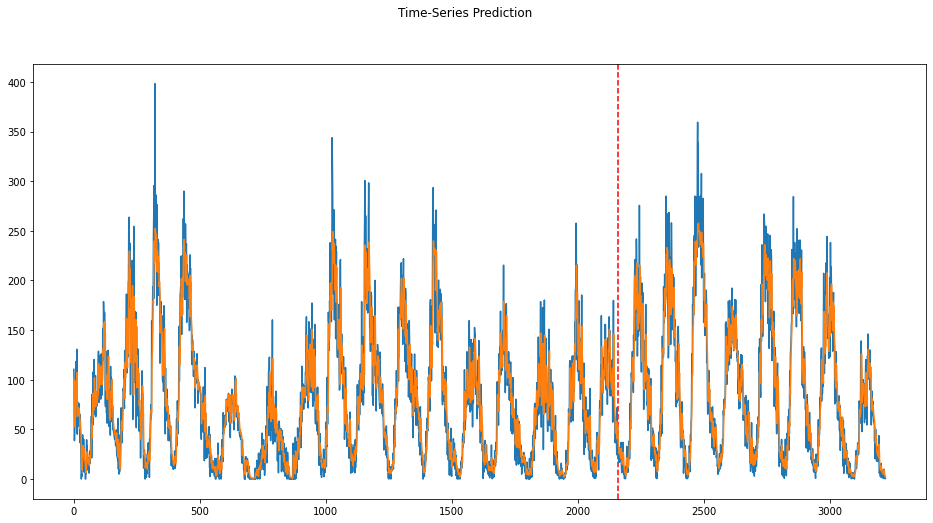

In [151]:
model.eval()
train_predict = model(dataX)

data_predict = train_predict.data.numpy()
dataY_plot = dataY.data.numpy()

data_predict = sc.inverse_transform(data_predict)
dataY_plot = sc.inverse_transform(dataY_plot)

plt.figure(figsize=(16, 8))
plt.axvline(x=train_size, c='r', linestyle='--')

plt.plot(dataY_plot)
plt.plot(data_predict)
plt.suptitle('Time-Series Prediction')
plt.show()

### Вывод:
В данной лабораторной работе были построенны модели для прогнозированния временных рядов, использовались модель ARIMA и рекуррентная сеть с двумя рекуррентными слоями.